In [1]:
from typing import *
from analysis.core.currency import Currency
from analysis.core.utils import load_data_from_currencies, compute_log_returns
from analysis.core.time_utils import Bounds
from datetime import date, timedelta


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# Current portfolio that we have
existing_portfolio: Dict[Currency, float] = {
    Currency.BTC: 0.6086,
    Currency.ETH: 0.105,
    Currency.XRP: 0.049,
    Currency.SOL: 0.0278,
    Currency.TRX: 0.0066,
    Currency.TON: 0.003,
    Currency.LINK: 0.0535,
    Currency.AAVE: 0.0175,
    Currency.ONDO: 0.0171,
    Currency.ENA: 0.0061,
    Currency.MOVE: 0.0057,
    Currency.HYPE: 0.0232,
    Currency.UNI: 0.0162,
    Currency.TAO: 0.0082,
    Currency.MKR: 0.0024,
    Currency.USDT: 0.0167 * 3
}

<h4>Check portfolios of different BTC/ETH combinations similar to VanEck report</h4>

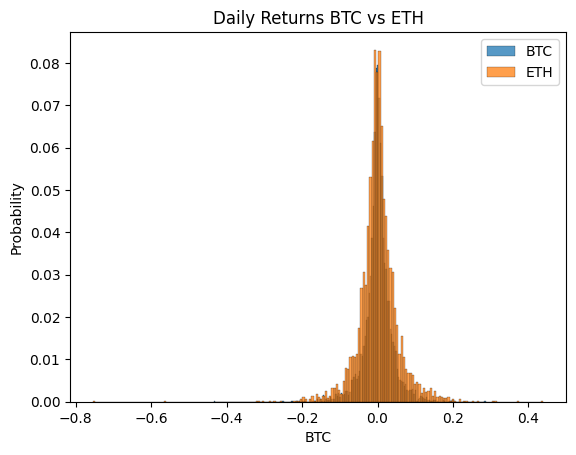

In [2]:
start_date: date = date(2013, 1, 1)
end_date: date = date(2025, 2, 28)
bounds: Bounds = Bounds.for_days(start_date, end_date)
selected_currencies: List[Currency] = [Currency.BTC, Currency.ETH]

df_prices: pd.DataFrame = load_data_from_currencies(bounds=bounds, currencies=selected_currencies)
df_returns: pd.DataFrame = compute_log_returns(df_prices=df_prices)

plt.title("Daily Returns BTC vs ETH")
sns.histplot(df_returns["BTC"], label="BTC", stat="probability")
sns.histplot(df_returns["ETH"], label="ETH", stat="probability")

plt.legend()
plt.show()

<h4>BTC and ETH 60%, 40% allocations</h4>

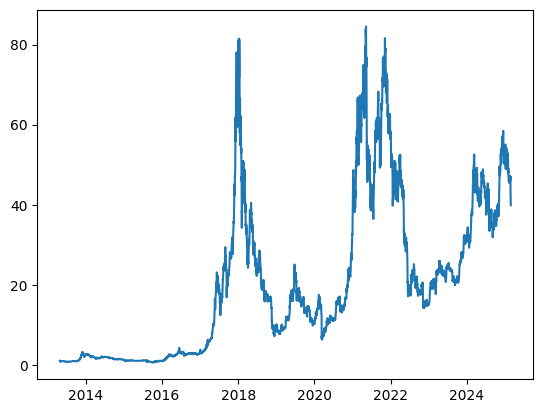

In [3]:
def compute_return_series_for_portfolio(df_returns: pd.DataFrame, portfolio: Dict[Currency, float]) -> pd.Series:
    currencies: List[str] = [currency.name for currency in portfolio]
    weights: np.ndarray = np.array(portfolio.values())

    return (df_returns[currencies] * weights).sum(axis=1)


portfolio_6040: Dict[Currency, float] = {
    Currency.BTC: 0.6, Currency.ETH: 0.4
}

returns: pd.Series = compute_return_series_for_portfolio(df_returns=df_returns, portfolio=portfolio_6040)

plt.plot((1 + returns).cumprod())
plt.show()

<h4>Other allocations of BTC/ETH</h4>

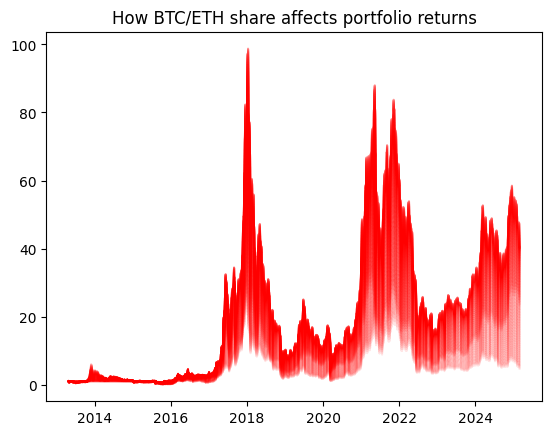

In [4]:
shares: np.ndarray = np.arange(0, 1.01, 0.01)
final_pnl: List[float] = []

for btc_share in np.arange(0, 1.01, 0.01):
    returns: pd.Series = compute_return_series_for_portfolio(
        df_returns=df_returns, 
        portfolio={Currency.BTC: btc_share, Currency.ETH: 1-btc_share}
    )
    final_pnl.append((1 + returns).prod())
    
    plt.plot((1 + returns).cumprod(), color="red", alpha=.1)

plt.title("How BTC/ETH share affects portfolio returns")
plt.show()

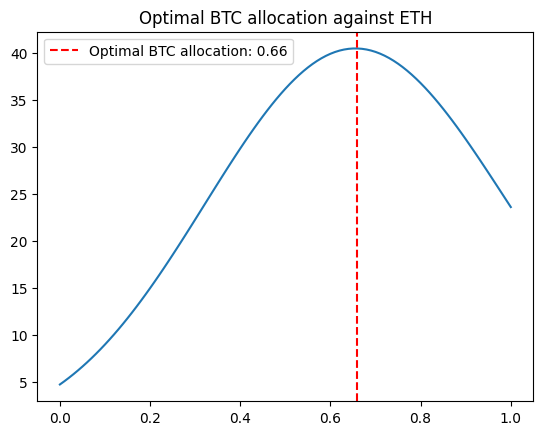

In [5]:
final_pnl = np.array(final_pnl)
optimal_btc_share: float = shares[final_pnl.argmax()]

plt.title("Optimal BTC allocation against ETH")
plt.plot(shares, final_pnl)
plt.axvline(optimal_btc_share, color="red", linestyle="--", label=f"Optimal BTC allocation: {optimal_btc_share}")
plt.legend()
plt.show()

<h4>If we take volatility of returns into account. Max Sharpe portfolio from BTC & ETH</h4>

In [6]:
# compute max sharpe portfolio
from analysis.portfolio_makers.max_sharpe import MaxSharpePortfolio


optimizer: MaxSharpePortfolio = MaxSharpePortfolio()
optimal_btc_eth_portfolio: Dict[Currency, float] = optimizer.find_portfolio(
    df_returns=df_returns, selected_currencies=[Currency.BTC, Currency.ETH]
)

optimal_btc_eth_portfolio

{<Currency.BTC: 2>: np.float64(0.6050926742340681),
 <Currency.ETH: 4>: np.float64(0.3949073257659318)}

Получаем похожую картинку, что кстати совпадает с нашим существующим портфелем

<h4>Compute historical stats of existing portfolio</h4>

Так как данных нет для всех активов, мы будем держать кэш до момента, когда появятся торги актива

In [7]:
today: date = date.today()
start_date: date = today - timedelta(days=180)

bounds: Bounds = Bounds.for_days(start_date, today)
df_prices: pd.DataFrame = load_data_from_currencies(bounds=bounds, currencies=list(existing_portfolio.keys()))
df_returns: pd.DataFrame = compute_log_returns(df_prices=df_prices)
df_returns[Currency.USDT.name] = 0

# fill missing returns with zeroes
df_returns = df_returns.fillna(0)

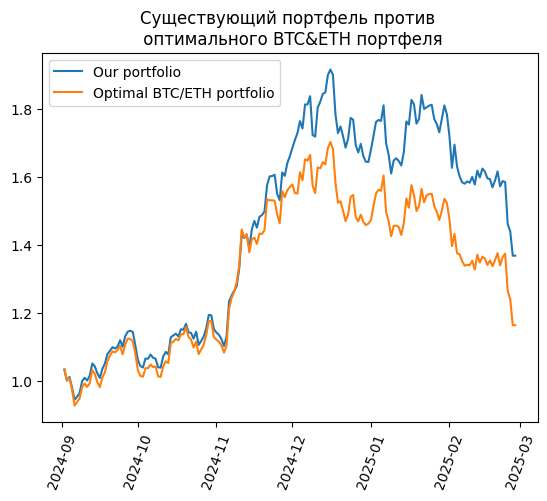

In [8]:
portfolio_returns: pd.Series = compute_return_series_for_portfolio(
    df_returns=df_returns, portfolio=existing_portfolio
)
optimal_btceth_returns: pd.Series = compute_return_series_for_portfolio(
    df_returns=df_returns, portfolio=optimal_btc_eth_portfolio
)

plt.title("Существующий портфель против \n оптимального BTC&ETH портфеля")
plt.plot((portfolio_returns + 1).cumprod(), label="Our portfolio")
plt.plot((optimal_btceth_returns + 1).cumprod(), label="Optimal BTC/ETH portfolio")
plt.legend()
plt.xticks(rotation=70)
plt.show()

In [9]:
from tqdm import tqdm


def compute_multiple_returns(offsets: List[timedelta]) -> pd.DataFrame:
    today: date = date.today()

    returns: List[Dict[str, float]] = []

    for offset in tqdm(offsets):
        bounds: Bounds = Bounds.for_days(today - offset, today)
        df_prices: pd.DataFrame = load_data_from_currencies(bounds=bounds, currencies=list(existing_portfolio.keys()))
        df_returns: pd.DataFrame = compute_log_returns(df_prices=df_prices)
        df_returns[Currency.USDT.name] = 0
        # fill missing returns with zeroes
        df_returns = df_returns.fillna(0)

        # Compute returns of BTC/ETH portfolio and existing portfolio
        existing_portfolio_returns: pd.Series = compute_return_series_for_portfolio(df_returns=df_returns, portfolio=existing_portfolio)
        optimal_btceth_returns: pd.Series = compute_return_series_for_portfolio(df_returns=df_returns, portfolio=optimal_btc_eth_portfolio)

        optimal_btceth_return: float = (optimal_btceth_returns + 1).prod()
        existing_portfolio_return: float = (existing_portfolio_returns + 1).prod()

        returns.append({
            "past": offset.days,
            "btceth_portfolio": optimal_btceth_return,
            "btceth_portfolio_annualized_return": (1 + optimal_btceth_returns.mean()) ** 365 - 1,
            "btceth_portfolio_annualized_vol": optimal_btceth_returns.std() * np.sqrt(365),
            "existing_portfolio": existing_portfolio_return,
            "existing_portfolio_annualized_return": (1 + existing_portfolio_returns.mean())**365 - 1,
            "existing_portfolio_annualized_vol": existing_portfolio_returns.std() * np.sqrt(365),
        })

    return pd.DataFrame(returns)

In [10]:
offsets: List[timedelta] = [
    timedelta(days=30),
    timedelta(days=90),
    timedelta(days=180),
    timedelta(days=365),
    timedelta(days=365*3),
    timedelta(days=365*5)
]

df_stats = compute_multiple_returns(offsets=offsets)

100%|██████████| 6/6 [00:01<00:00,  5.71it/s]


In [11]:
df_stats["btceth_sharpe_ratio"] = df_stats["btceth_portfolio_annualized_return"] / df_stats["btceth_portfolio_annualized_vol"]
df_stats["existing_portfolio_sharpe_ratio"] = df_stats["existing_portfolio_annualized_return"] / df_stats["existing_portfolio_annualized_vol"]

<h4>Overall return</h4>

In [12]:
df_stats[["past", "btceth_portfolio", "existing_portfolio"]]

,past,btceth_portfolio,existing_portfolio
0,30,0.775165,0.772542
1,90,0.741145,0.823824
2,180,1.163688,1.368133
3,365,0.905103,1.126383
4,1095,0.827858,1.109180
5,1825,2.872834,3.150367


<h4>Annualized Sharpe ratios</h4>

In [13]:
df_stats[["past", "btceth_sharpe_ratio", "existing_portfolio_sharpe_ratio"]]

,past,btceth_sharpe_ratio,existing_portfolio_sharpe_ratio
0,30,-1.896465,-1.956666
1,90,-1.350717,-0.995837
2,180,1.082999,2.344852
3,365,0.087201,0.552255
4,1095,0.179030,0.349556
5,1825,0.853448,0.860512


<h4>Annualized returns</h4>

In [14]:
df_stats[["past", "btceth_portfolio_annualized_return", "existing_portfolio_annualized_return"]]

,past,btceth_portfolio_annualized_return,existing_portfolio_annualized_return
0,30,-0.954000,-0.956256
1,90,-0.668931,-0.490068
2,180,0.542985,1.123281
3,365,0.047314,0.276954
4,1095,0.100383,0.175434
5,1825,0.588380,0.513658


<h4>Annualized volatility</h4>

In [15]:
df_stats[["past", "btceth_portfolio_annualized_vol", "existing_portfolio_annualized_vol"]]

,past,btceth_portfolio_annualized_vol,existing_portfolio_annualized_vol
0,30,0.503041,0.488717
1,90,0.495241,0.492117
2,180,0.501371,0.479041
3,365,0.542592,0.501496
4,1095,0.560705,0.501877
5,1825,0.689416,0.596921


<h4>Если мы делаем ребаланс, то есть строим совершенно новые портфели каждый месяц, используя данные за последние 3 месяца</h4>

In [16]:
def compute_return_series_of_actively_rebalanced_portfolio(
    bounds: Bounds, interval: timedelta, step: timedelta, use_currencies: List[Currency]
) -> pd.Series:
    df_prices: pd.DataFrame = load_data_from_currencies(bounds=bounds, currencies=use_currencies)
    df_returns: pd.DataFrame = compute_log_returns(df_prices=df_prices)
    
    df_returns[Currency.USDT.name] = 0
    # fill missing returns with zeroes
    df_returns = df_returns.fillna(0)
    
    overlapping_bounds: List[Bounds] = bounds.generate_overlapping_bounds(step=step, interval=interval)
    
    returns_tss: List[pd.Series] = []
    
    for sub_bounds in tqdm(overlapping_bounds):
        portfolio: Dict[Currency, float] = optimizer.find_portfolio(
            df_returns=df_returns.loc[sub_bounds.day0: sub_bounds.day1], selected_currencies=list(Currency)
        )
        returns = compute_return_series_for_portfolio(
            df_returns=df_returns.loc[sub_bounds.day1: sub_bounds.day1 + timedelta(days=30)],
            portfolio=portfolio
        )
        returns_tss.append(returns)

    return pd.concat(returns_tss)

In [17]:
bounds: Bounds = Bounds.for_days(
    start_date=date.today() - timedelta(days=270), end_date=date.today()
)

actively_rebalanced_portfolio_returns: pd.Series = compute_return_series_of_actively_rebalanced_portfolio(
    bounds=bounds, interval=timedelta(days=90), step=timedelta(days=30), use_currencies=list(Currency)
)

100%|██████████| 8/8 [00:00<00:00, 215.84it/s]


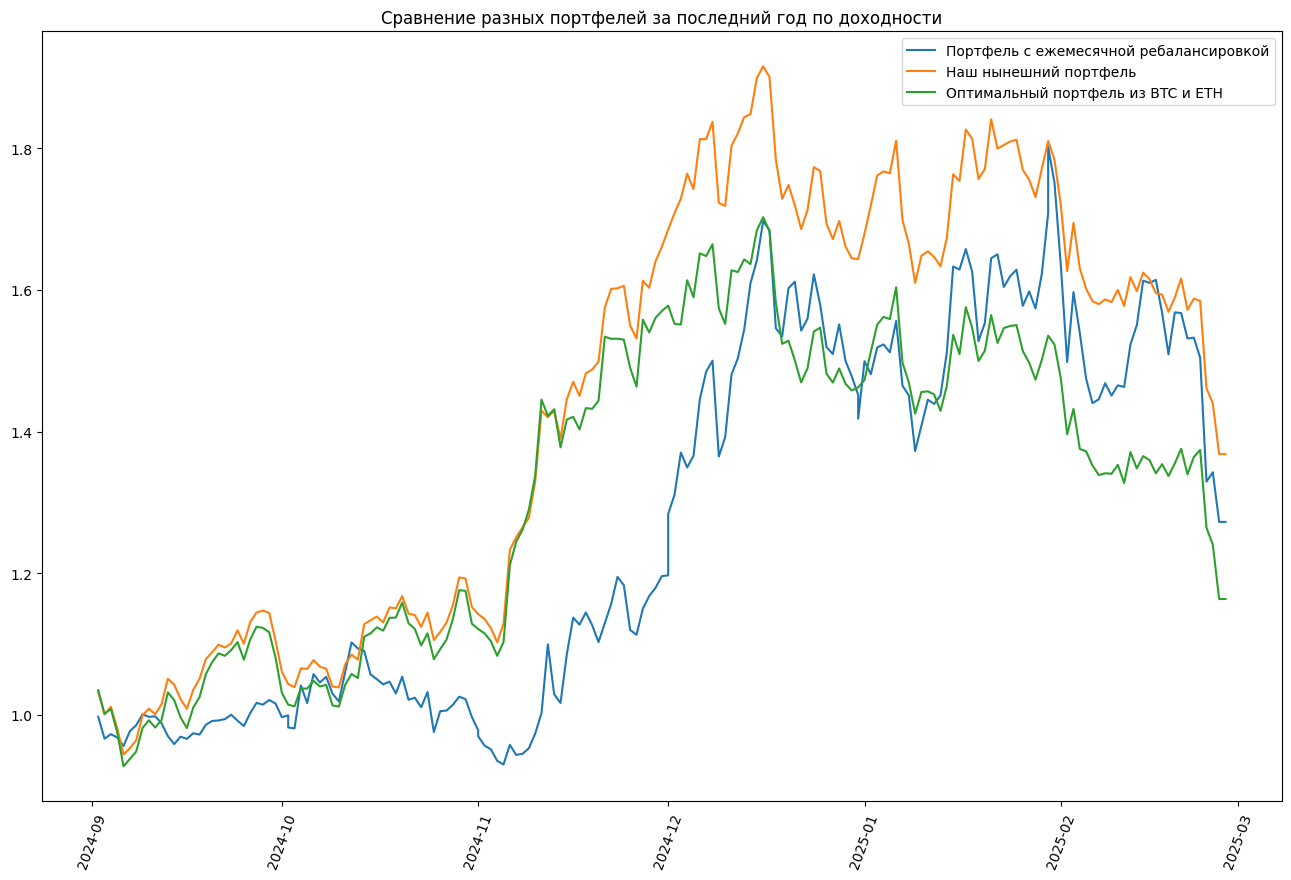

In [18]:
plt.figure(figsize=(16, 10))

plt.title("Сравнение разных портфелей за последний год по доходности")
plt.plot((1 + actively_rebalanced_portfolio_returns).cumprod(), label="Портфель с ежемесячной ребалансировкой")
plt.plot((portfolio_returns + 1).cumprod(), label="Наш нынешний портфель")
plt.plot((optimal_btceth_returns + 1).cumprod(), label="Оптимальный портфель из BTC и ETH")

plt.legend()
plt.xticks(rotation=70)
plt.savefig("three_strategies_compared.png")
plt.show()

In [19]:
stats: List[Dict[str, Any]] = []

for offset in offsets:
    bounds: Bounds = Bounds.for_days(
        start_date=date.today() - offset, end_date=date.today()
    )
    actively_rebalanced_portfolio_returns: pd.Series = compute_return_series_of_actively_rebalanced_portfolio(
        bounds=bounds, interval=timedelta(days=90), step=timedelta(days=30), use_currencies=list(Currency)
    )
    stats.append({
        "past": offset.days,
        "portfolio_rebalanced_90/30": (actively_rebalanced_portfolio_returns + 1).prod(),
        "portfolio_rebalanced_90/30_annualized_return": (1 + actively_rebalanced_portfolio_returns.mean()) ** 252 - 1,
        "portfolio_rebalanced_90/30_annualized_std": actively_rebalanced_portfolio_returns.std() * np.sqrt(252)
    })

100%|██████████| 59/59 [00:00<00:00, 233.67it/s]


In [20]:
df_rebalanced = pd.DataFrame(stats)
df_rebalanced["sharpe_ratio"] = (
    df_rebalanced["portfolio_rebalanced_90/30_annualized_return"] / df_rebalanced["portfolio_rebalanced_90/30_annualized_std"]
)

df_rebalanced

,past,portfolio_rebalanced_90/30,portfolio_rebalanced_90/30_annualized_return,portfolio_rebalanced_90/30_annualized_std,sharpe_ratio
0,30,1.000000,NaN,NaN,NaN
1,90,1.000000,NaN,NaN,NaN
2,180,1.063040,0.421266,0.603595,0.697928
3,365,0.940724,0.055519,0.464282,0.119580
4,1095,3.900163,0.553363,0.469368,1.178953
5,1825,3.217703,0.449107,0.642193,0.699333


<h4>All Sharpe ratios</h4>

In [21]:
df_all = pd.concat([df_stats, df_rebalanced], axis=1)
df_all[["past", "btceth_sharpe_ratio", "existing_portfolio_sharpe_ratio", "sharpe_ratio"]].iloc[:, 1:]

,past,btceth_sharpe_ratio,existing_portfolio_sharpe_ratio,sharpe_ratio
0,30,-1.896465,-1.956666,NaN
1,90,-1.350717,-0.995837,NaN
2,180,1.082999,2.344852,0.697928
3,365,0.087201,0.552255,0.119580
4,1095,0.179030,0.349556,1.178953
5,1825,0.853448,0.860512,0.699333


<h4>All Annualized returns</h4>

In [22]:
df_all[
    ["past", "btceth_portfolio_annualized_return", "existing_portfolio_annualized_return", "portfolio_rebalanced_90/30_annualized_return"]
].iloc[:, 1:]

,past,btceth_portfolio_annualized_return,existing_portfolio_annualized_return,portfolio_rebalanced_90/30_annualized_return
0,30,-0.954000,-0.956256,NaN
1,90,-0.668931,-0.490068,NaN
2,180,0.542985,1.123281,0.421266
3,365,0.047314,0.276954,0.055519
4,1095,0.100383,0.175434,0.553363
5,1825,0.588380,0.513658,0.449107


<h4>All total returns</h4>

In [23]:
df_all[
    ["past", "btceth_portfolio", "existing_portfolio", "portfolio_rebalanced_90/30"]
].iloc[:, 1:]

,past,btceth_portfolio,existing_portfolio,portfolio_rebalanced_90/30
0,30,0.775165,0.772542,1.000000
1,90,0.741145,0.823824,1.000000
2,180,1.163688,1.368133,1.063040
3,365,0.905103,1.126383,0.940724
4,1095,0.827858,1.109180,3.900163
5,1825,2.872834,3.150367,3.217703
